In [ ]:
%pip install git+https://github.com/coax-dev/coax.git@main --quiet

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./data/tensorboard

In [14]:
!pip install shutup
##At the top of the code
import shutup;
shutup.please()

In [15]:
# Run this cell to fix rendering errors.
import os
os.environ['SDL_VIDEODRIVER'] = 'dummy'

In [24]:
import gymnasium
import jax
import jax.numpy as jnp
import coax
import haiku as hk
from numpy import prod
import optax


# the name of this script
name = 'ppo'

# the Pendulum MDP
env = gymnasium.make('VDP-v0')#, render_mode='rgb_array')
env = coax.wrappers.TrainMonitor(env, name=name, tensorboard_dir=f"./data/tensorboard/{name}")


def func_pi(S, is_training):
    shared = hk.Sequential((
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
    ))
    mu = hk.Sequential((
        shared,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(prod(env.action_space.shape), w_init=jnp.zeros),
        hk.Reshape(env.action_space.shape),
    ))
    logvar = hk.Sequential((
        shared,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(prod(env.action_space.shape), w_init=jnp.zeros),
        hk.Reshape(env.action_space.shape),
    ))
    return {'mu': mu(S), 'logvar': logvar(S)}


def func_v(S, is_training):
    seq = hk.Sequential((
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(1, w_init=jnp.zeros), jnp.ravel
    ))
    return seq(S)


# define function approximators
pi = coax.Policy(func_pi, env)
v = coax.V(func_v, env)


# target network
pi_targ = pi.copy()


# experience tracer
tracer = coax.reward_tracing.NStep(n=5, gamma=0.9)
buffer = coax.experience_replay.SimpleReplayBuffer(capacity=512)


# policy regularizer (avoid premature exploitation)
policy_reg = coax.regularizers.EntropyRegularizer(pi, beta=0.01)


# updaters
simpletd = coax.td_learning.SimpleTD(v, optimizer=optax.adam(1e-3))
ppo_clip = coax.policy_objectives.PPOClip(pi, regularizer=policy_reg, optimizer=optax.adam(1e-4))


# train
while env.T < 500000:
    s, info = env.reset()

    for t in range(env.spec.max_episode_steps):
        a, logp = pi_targ(s, return_logp=True)
        s_next, r, done, truncated, info = env.step(a)
    #include for inverted pendulum
        #if done:  r=-1000
        # trace rewards
        tracer.add(s, a, r, done or truncated, logp)
        while tracer:
            buffer.add(tracer.pop())

        # learn
        if len(buffer) >= buffer.capacity:
            for _ in range(int(4 * buffer.capacity / 32)):  # 4 passes per round
                transition_batch = buffer.sample(batch_size=32)
                metrics_v, td_error = simpletd.update(transition_batch, return_td_error=True)
                metrics_pi = ppo_clip.update(transition_batch, td_error)
                env.record_metrics(metrics_v)
                env.record_metrics(metrics_pi)

            buffer.clear()
            pi_targ.soft_update(pi, tau=0.1)

        if done or truncated:
            break

        s = s_next

    # generate an animated GIF to see what's going on
    #uncomment for "real" gymns
    # if env.period(name='generate_gif', T_period=1000) and env.T > 5000:
    #     T = env.T - env.T % 1000  # round to 10000s
    #     coax.utils.generate_gif(
    #         env=env, policy=pi, filepath=f"./data/gifs/{name}/T{T:08d}.gif")


INFO:TrainMonitor:ep: 1,	T: 501,	G: 232,	avg_r: 0.465,	avg_G: 232,	t: 500,	dt: 5.295ms
INFO:TrainMonitor:ep: 2,	T: 1,002,	G: 63.5,	avg_r: 0.127,	avg_G: 148,	t: 500,	dt: 8.961ms,	SimpleTD/loss: 1.33,	PPOClip/EntropyRegularizer/entropy: 1.42,	PPOClip/loss: -1
INFO:TrainMonitor:ep: 3,	T: 1,503,	G: 137,	avg_r: 0.275,	avg_G: 144,	t: 500,	dt: 4.166ms,	SimpleTD/loss: 0.025,	PPOClip/EntropyRegularizer/entropy: 1.43,	PPOClip/loss: -0.0897
INFO:TrainMonitor:ep: 4,	T: 2,004,	G: 111,	avg_r: 0.222,	avg_G: 136,	t: 500,	dt: 3.178ms,	SimpleTD/loss: 0.124,	PPOClip/EntropyRegularizer/entropy: 1.43,	PPOClip/loss: -0.369
INFO:TrainMonitor:ep: 5,	T: 2,505,	G: 146,	avg_r: 0.292,	avg_G: 138,	t: 500,	dt: 3.254ms,	SimpleTD/loss: 0.0376,	PPOClip/EntropyRegularizer/entropy: 1.43,	PPOClip/loss: 0.0398
INFO:TrainMonitor:ep: 6,	T: 3,006,	G: 182,	avg_r: 0.363,	avg_G: 145,	t: 500,	dt: 3.976ms,	SimpleTD/loss: 0.038,	PPOClip/EntropyRegularizer/entropy: 1.43,	PPOClip/loss: -0.136
INFO:TrainMonitor:ep: 7,	T: 3,507,	G: 70

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

env = gymnasium.make("Pendulum", render_mode="human")
observation, info = env.reset()
s=observation
for i in range(500):
    a, logp = pi(s, return_logp=True)
    print(i, a)
    obs, reward, terminated, truncated, info = env.step(a)
    s=obs
    # clear_output(wait=True)
    # plt.imshow( env.render(mode='rgb_array') )
    # plt.show()
    image = env.render()
    #img = cv2.imread('a.jpg')
    if (terminated or truncated):  break
env.close()

[5.75897791 5.64445207]
0.13189253470040255
0.13905043747084866
0.1453210567039483
0.15071375623318542
0.15518403298011668
0.15885685808499372
0.1618172898883931
0.16419568014875893
0.16603715579853465
0.1675233435671906
0.1686419772419266
0.1695123603428733
0.17020152493463106
0.17070958235025624
0.1710887689628868
0.17138591318173643
0.17162060571542276
0.17177865100250617
0.1719098410996467
0.1720015440392535
0.17207382269253044
0.17212596775183747
0.17216667813420683
0.17220449966611234
0.17222928105280777
0.17224406332803854
0.17225450345008303
0.17226496010970632
0.1722692164454025
0.17227377347887038
0.17227611180735852
0.17227822607364063
0.17228324807225545
0.17228216349765865
0.17228222873240306
0.17228282827994976
0.17228275959743897
0.17228117836584023
0.17228217561996267
0.1722824289493898
0.1722807057475146
0.172278216347338
0.1722780660407451
0.1722769054689914
0.17227609280791192
0.17227384667595672
0.17227162808141944
0.1722693611656371
0.17226741177648375
0.1722654486

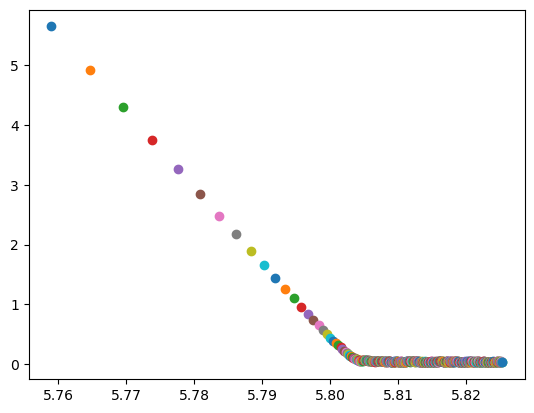

[5.82522855 0.03645682]


In [23]:
#display for van der pol
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import gymnasium

env = gymnasium.make("VDP-v0")
observation, info = env.reset()
s=observation

#s=np.array([0.5,0.5])
x=s[0]
y=s[1]
print(s)
plt.figure(1)
plt.scatter(x,y)#,'ro')
for i in range(1000):
    a, logp = pi(s, return_logp=True)
    #a=0
    obs, reward, terminated, truncated, info = env.step(a)
    s=obs
    x=s[0]
    y=s[1]
    plt.scatter(x, y)
    print(reward)
    if (terminated or truncated):  break
env.close()
plt.show()
print(s)

In [2]:
env = gymnasium.make("VDP-v0")
env.reset()

C:\Users\robert\anaconda3\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment VDP-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


(array([-5.05068436, -6.20647905]), {})

In [6]:
print(s[:,1])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed